# Distributional Thesaurus impact on LOS
This notebook demonstrates to what extend the application of the
DT approach (Kumar 2016) changes the similarity between lexicons. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from social_sent_helpers import list_lexicons, read_all_lexicons, read_lexicon
import os
from qlex import los
from tqdm.notebook import trange

In [2]:
use_lexs = ["starcitizen", "funny", "motorcycles", "aww", "books", "Drugs", "hockey"]

In [3]:
def binary_so(x):
    return "pos" if x > 0 else "neg"

# If not running on windows, change file ending accordingly
os.remove("./dt_impact/run.ps1")
with open("./dt_impact/run.ps1", "a") as shell_script:

    for lex_name in use_lexs:
        lex = read_lexicon(lex_name)
        lex["bin"] = lex.so.map(binary_so)
        file_name = "in_" + lex_name
        file_out_name = "out_" + lex_name
        lex[["word", "bin"]].sample(frac=1).to_csv("./dt_impact/" + file_name, sep=";", header=None, index=None)
        shell_script.write("java -jar .\LexiExp-0.0.1-jar-with-dependencies.jar -s "+file_name+" -o "+file_out_name+"\n")


In [4]:
exp_lexs = []
for lex_name in use_lexs:
    expand_lex = pd.read_csv("./dt_impact/out_"+lex_name, sep="\t")
    expand_lex.neg = pd.to_numeric(expand_lex.neg.str.replace(",", "."))
    expand_lex.pos = pd.to_numeric(expand_lex.pos.str.replace(",", "."))
    expand_lex["so"] = expand_lex.apply(lambda x: x.pos - x.neg, axis=1)
    exp_lexs.append(expand_lex)

In [5]:
dd = exp_lexs[0]

In [6]:
dd.head(2)

word     neg     pos      so
0  undermining  0.0004  0.0000 -0.0004
1          Rap  0.0000  0.0004  0.0004

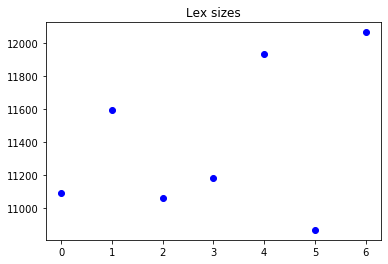

In [7]:
plt.plot([len(d) for d in exp_lexs], "bo")
plt.title("Lex sizes")
plt.show()

In [5]:
def merge_df(exp_lex, start_lex):
    return pd.concat([exp_lex.drop(["neg", "pos"], axis=1), start_lex.drop("sd", axis=1)]).reset_index(drop=True)

In [6]:
merged_lexs = [merge_df(exp_lexs[i], read_lexicon(use_lexs[i])) for i in range(len(use_lexs))]

In [8]:
start_los_scores = np.zeros((len(use_lexs), len(use_lexs)))
expand_los_scores = np.zeros((len(use_lexs), len(use_lexs)))

start_lexs = [read_lexicon(lex_name) for lex_name in use_lexs]
for i in trange(len(use_lexs)):
    for j in range(i, len(use_lexs)):
        bi_start = los.binary(start_lexs[i], start_lexs[j])
        bi_expand = los.binary(merged_lexs[i], merged_lexs[j])

        start_los_scores[i, j] = bi_start
        start_los_scores[j, i] = bi_start
        expand_los_scores[i, j] = bi_expand
        expand_los_scores[j, i] = bi_expand
        

start_los_scores, expand_los_scores = np.around(start_los_scores, 2), np.around(expand_los_scores, 2)
start_los_scores, expand_los_scores, expand_los_scores - start_los_scores

(array([[1.  , 0.29, 0.31, 0.27, 0.27, 0.26, 0.24],
        [0.29, 1.  , 0.34, 0.45, 0.35, 0.3 , 0.35],
        [0.31, 0.34, 1.  , 0.31, 0.26, 0.29, 0.29],
        [0.27, 0.45, 0.31, 1.  , 0.28, 0.29, 0.29],
        [0.27, 0.35, 0.26, 0.28, 1.  , 0.28, 0.26],
        [0.26, 0.3 , 0.29, 0.29, 0.28, 1.  , 0.23],
        [0.24, 0.35, 0.29, 0.29, 0.26, 0.23, 1.  ]]),
 array([[1.  , 0.34, 0.35, 0.32, 0.3 , 0.31, 0.28],
        [0.34, 1.  , 0.38, 0.47, 0.38, 0.34, 0.38],
        [0.35, 0.38, 1.  , 0.36, 0.29, 0.34, 0.33],
        [0.32, 0.47, 0.36, 1.  , 0.31, 0.34, 0.34],
        [0.3 , 0.38, 0.29, 0.31, 1.  , 0.31, 0.3 ],
        [0.31, 0.34, 0.34, 0.34, 0.31, 1.  , 0.28],
        [0.28, 0.38, 0.33, 0.34, 0.3 , 0.28, 1.  ]]),
 array([[0.  , 0.05, 0.04, 0.05, 0.03, 0.05, 0.04],
        [0.05, 0.  , 0.04, 0.02, 0.03, 0.04, 0.03],
        [0.04, 0.04, 0.  , 0.05, 0.03, 0.05, 0.04],
        [0.05, 0.02, 0.05, 0.  , 0.03, 0.05, 0.05],
        [0.03, 0.03, 0.03, 0.03, 0.  , 0.03, 0.04],
        

In [9]:
def rem_diag(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
rem_diag(np.array([
    [0, 4, 3],
    [3, 0, 7],
    [8, 2, 0]
]))

array([[4, 3],
       [3, 7],
       [8, 2]])

Text(0.5, 0, 'Binary lexicon overlap score')

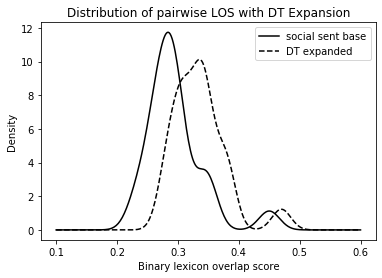

In [11]:
pd.DataFrame({
    "social sent base": rem_diag(start_los_scores).flatten(),
    "DT expanded": rem_diag(expand_los_scores).flatten()
}).plot.density(ind=np.linspace(0.1, 0.6, 300), bw_method=0.36, style=["-", "--"], 
                colormap=lambda x: "black", title="Distribution of pairwise LOS with DT Expansion")
plt.xlabel("Binary lexicon overlap score")

In [37]:
pd.DataFrame(rem_diag(expand_los_scores - start_los_scores).flatten()).describe()

0
count  42.00000
mean    0.04000
std     0.00937
min     0.02000
25%     0.03000
50%     0.04000
75%     0.05000
max     0.05000

(array([ 7.,  0.,  0.,  2.,  0.,  8.,  4.,  6.,  6., 16.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 ]),
 <a list of 10 Patch objects>)

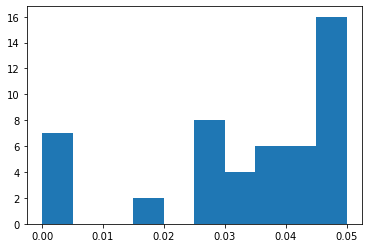

In [16]:
plt.hist((expand_los_scores - start_los_scores).flatten())